In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import corner

In [2]:
Nhomework = 13

rng = np.random.default_rng()

i = rng.integers(0, Nhomework) + 1
print(i)

2


<ErrorbarContainer object of 3 artists>

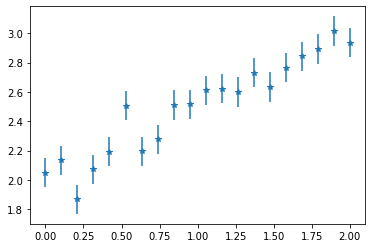

In [3]:
# generating Gaussian data around an affine relation

a = 2
b = 0.5

x = np.linspace(0, 2, num=20)

sig = 0.1 # all the errorbars
# mean relation
m = a + b*x

# generate the data y
y = m + sig*rng.normal(size=len(x))

plt.errorbar(x, y, yerr=sig, fmt='*')



In [4]:
# the log likelihood of this data is given by

def like_affine(params, data=(y, x, sig*np.ones(len(x)))):
    '''
    
    define properly...
    '''
    
    y, x, sigma = data
    
    a, b = params
    
    res = y - a - b*x
    
    # likelihood of each data point
    lnL = -0.5*np.log(sigma**2) - 0.5*res**2/sigma**2
    
    return np.sum(lnL) # assuming the errorbars are independent

In [5]:
class MetropolisHastingsSampler:
    
    def __init__(self, lnp, seed=1492):
        
        self.lnp = lnp
        self._rng = np.random.default_rng(seed=seed)

    def __call__(self, prop, Niter, start):
        """
        prop: generate a proposal point given a starting point
        start: starting point of the sampler
        Niter: number of iterations
        """
        
        points = [start, ]
        count = 0
        
        for i in range(Niter):
            x_prop = prop(start)
            xnew, accept = self._a_step(x_prop, start)
            count += accept
            points.append(xnew)
            
            start = xnew
        
        return np.array(points), count/Niter
    
    def _a_step(self, x_prop, x_old):
        
        alpha = np.exp( self.lnp(x_prop) - self.lnp(x_old) )
        
        u = self._rng.uniform()
        
        if u<alpha:
            return x_prop, 1
        else:
            return x_old, 0
        
      
        

True
[1.99530671 0.50333678]
[0.04309458 0.03683942]


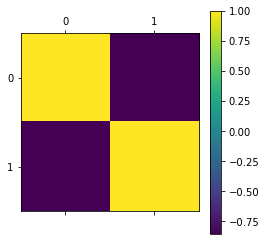

In [6]:
# with flat priors, 
# maximum likelihood is also the maximum of the posterior
# btw. our posterior is ~ exp(quadratic stuff an a and b), 
# ergo it's a Gaussian in (a,b). As such, mean, median and maximum fall together

f = lambda theta: -like_affine(theta)

res = minimize(f, [1.5, 0.7], tol=0.1)

print(res.success)
print(res.x)

cov = res.hess_inv
s_theta = np.sqrt(np.diag(cov))
print(s_theta)

# correlation matrix
corr = cov/s_theta[:, None]/s_theta[None, :]

plt.matshow(corr)
plt.colorbar()


In [7]:
Niter = int(1e5)

sampler_mh = MetropolisHastingsSampler(like_affine)

def GaussianProp(y):
    return rng.multivariate_normal(y, cov)

pnts, accep = sampler_mh(GaussianProp, Niter, res.x)

print(accep)

0.55182


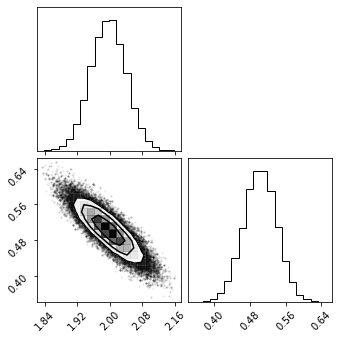

In [8]:
figure = corner.corner(pnts)

(100001, 2)


<ErrorbarContainer object of 3 artists>

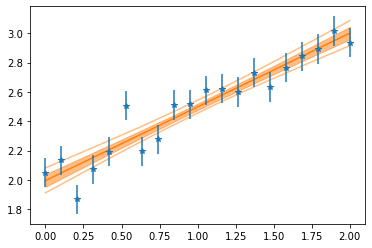

In [9]:
# posterior predictive for m(x)

xx = np.linspace(0, 2, num=1000)

print(pnts.shape)
thin = 10

m_MC = pnts[::thin, [0]] + pnts[::thin, [1]]*xx[None, :]

d2, d1, mm, u1, u2 = np.percentile(m_MC, [2.5, 16, 50, 84, 97.5],
                                 axis=0)

plt.plot(xx, mm, c='C1')
plt.fill_between(xx, d1, u1, alpha=0.5, color='C1')
plt.plot(xx, d2, c='C1', alpha=0.5)
plt.plot(xx, u2, c='C1', alpha=0.5)
plt.errorbar(x, y, yerr=sig, fmt='*')

In [10]:
# uh, a strong anticorrelation between a and b

# y =  a + b * x 

# Homework: show the correlation is much smaller once you adopt the model 
# y_i ~ N( mean(y) + a + b * ( x_i-mean(x) ), sigma^2)
# sigma is still the reported errorbars


# Homework

The model covariance : [0.0005     0.00135714]
The previouse covariance : [0.00185714 0.00135714]


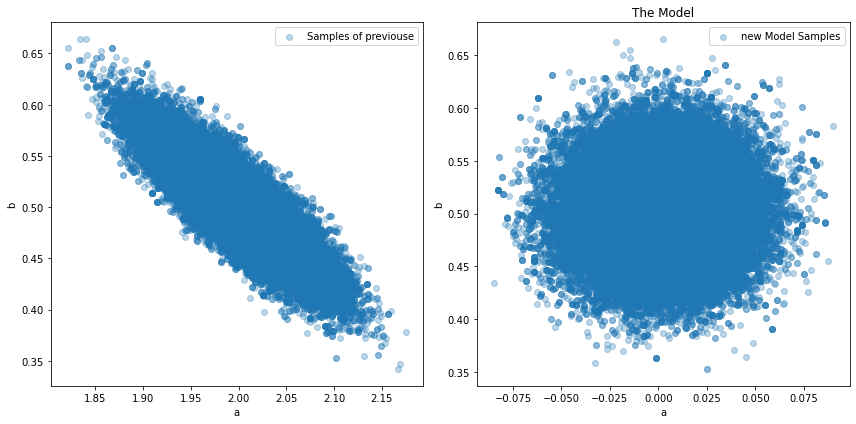

In [12]:
# likelihood for the model
def like_centered(params, data=(y, x, sig*np.ones(len(x)))):
    """
    Log-likelihood for the centered model.
    """
    y, x, sigma = data
    mean_y, mean_x = np.mean(y), np.mean(x)
    a, b = params
    res = y - mean_y - a - b * (x - mean_x)
    lnL = -0.5 * np.log(sigma**2) - 0.5 * res**2 / sigma**2
    return np.sum(lnL)




# the MLE for the model
f_centered = lambda theta: -like_centered(theta)
res_centered = minimize(f_centered, [1.5, 0.7], tol=0.1)


cov_centered = res_centered.hess_inv
s_theta_centered = np.sqrt(np.diag(cov_centered))




# Sample from the posterior using Metropolis-Hastings
sampler_mh_centered = MetropolisHastingsSampler(like_centered)
def GaussianProp_centered(y):
    return rng.multivariate_normal(y, cov_centered)

pnts_centered, accep_centered = sampler_mh_centered(GaussianProp_centered, Niter, res_centered.x)


print (f"The model covariance : {np.diag(cov_centered)}")
print (f"The previouse covariance : {np.diag (cov)}")


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# The previouse samples
axs[0].scatter(pnts[:, 0], pnts[:, 1], alpha=0.3, label="Samples of previouse")
axs[0].set_xlabel("a")
axs[0].set_ylabel("b")
axs[0].legend()

# The new model samples 
axs[1].scatter(pnts_centered[:, 0], pnts_centered[:, 1], alpha=0.3, label="new Model Samples")
axs[1].set_title("The Model")
axs[1].set_xlabel("a")
axs[1].set_ylabel("b")
axs[1].legend()

plt.tight_layout()
plt.show()


In [14]:
# Bayesian inference is very versatile :D
# what if the data comes without errorbars sigma
# --> just fit for sigma

def like_affine(params, data=(y, x) ):
    '''
    
    define properly...
    '''
    y, x = data
    
    a, b, lnsigma2 = params
    
    sigma = np.exp(0.5*lnsigma2)
    
    res = y - a - b*x
    
    # likelihood of each data point
    lnL = -0.5*np.log(sigma**2) - 0.5*res**2/sigma**2
    
    return np.sum(lnL) # assuming the errorbars are independent


True
[ 1.99528152  0.50336414 -4.62392475]
[0.04340722 0.0371343  0.37190408]


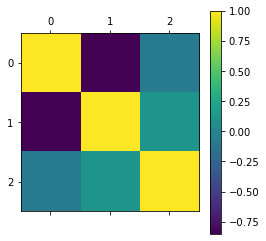

In [15]:

f = lambda theta: -like_affine(theta)

res = minimize(f, [1.5, 0.7, np.log(0.2**2)], tol=0.1)

print(res.success)
print(res.x)

cov = res.hess_inv
s_theta = np.sqrt(np.diag(cov))
print(s_theta)

# correlation matrix
corr = cov/s_theta[:, None]/s_theta[None, :]

plt.matshow(corr)
plt.colorbar()



In [16]:
Niter = int(1e5)

sampler_mh = MetropolisHastingsSampler(like_affine)

def GaussianProp(y):
    return rng.multivariate_normal(y, cov)

pnts, accep = sampler_mh(GaussianProp, Niter, res.x)

print(accep)

0.44052


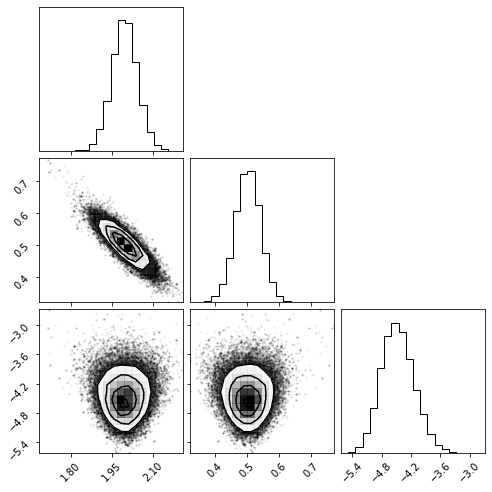

In [17]:
figure = corner.corner(pnts)

0.10883356518880316 0.01937770224962949


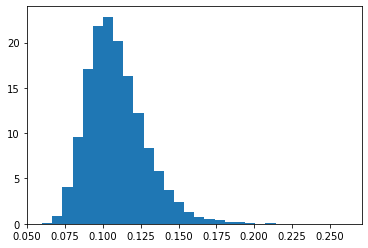

In [18]:
post_sigma = np.exp(0.5*pnts[:, 2])

_ = plt.hist(post_sigma, bins=30, density=True)

print(np.mean(post_sigma), np.std(post_sigma))

In [19]:
# talk about link to chi2

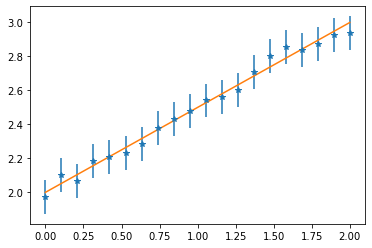

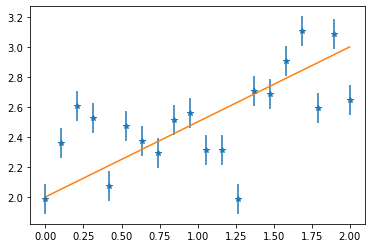

In [21]:
# the stocasticity of the generative model shows in the 
# fact that the data scatters around the mean relation.
# Note that the data has to scatter the right amount.
# this amount is given by the Gaussian distribution
# we used / assumed to generate the data.
# As a rule of thumb, 1/3 of the point scatter more than
# one standard deviation and 1/20 more than two 
# standard deviations, colloquially "1 or 2 sigma".

#Examples of too much and too little scatter

a = 2
b = 0.5

x = np.linspace(0, 2, num=20)

sig = 0.1 # all the errorbars
# mean relation
m = a + b*x

# generate the data y
y1 = m + 0.5*sig*rng.normal(size=len(x))
y2 = m + 3*sig*rng.normal(size=len(x))

plt.figure()
plt.errorbar(x, y1, yerr=sig, fmt='*')
plt.plot(xx, a+ b*xx)

plt.figure()
plt.errorbar(x, y2, yerr=sig, fmt='*')
plt.plot(xx, a+ b*xx)



In [22]:
# Homework: fit for the variances of y1 and y2 
# (the data vectors above, where we had the wrong errorbars)

# I propose the following generative model
# y_i ~ N(a + b*x_i, \lambda^2 sigma^2_i)

# introduce the extra parameters ln lambda**2

# derive the likelihood function for this generative model

# sample to check that:
# 1) a and b a recovered correctly
# 2) the scaled errorbars show the "right" amount of scatter

## Homework 2 :

### Generative Model

\$y_i \sim N(a + b \cdot x_i, \lambda^2 \cdot \sigma_i^2)\$


### Likelihood Function

\$\ln L(a, b, \ln(\lambda^2)) = -\frac{1}{2} \sum_i \left[ \ln(2 \pi \lambda^2 \sigma_i^2) + \frac{(y_i - (a + bx_i))^2}{\lambda^2 \sigma_i^2} \right]\$

Here, \$(\lambda^2 = e^{\ln(\lambda^2)}\)$.

---

### Fit Parameters

Use **Maximum Likelihood Estimation (MLE)** to fit the parameters:
- \(a\): Intercept
- \(b\): Slope
- \$(\ln(\lambda^2)\)$ : Logarithm of the scaling factor.



Fitted parameters for y1: [ 2.00113305  0.4986386  -2.16781349]
Fitted parameters for y2: [2.19509339 0.30961027 1.74910651]


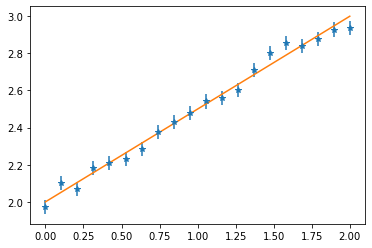

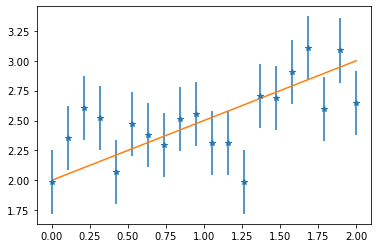

In [23]:
def log_likelihood(params, data):
    """
    Log-likelihood for the generative model:
    y_i ~ N(a + b * x_i, lambda^2 * sigma^2)
    """
    y, x, sigma = data
    a, b, ln_lambda2 = params
    
    lambda2 = np.exp(ln_lambda2)  # Transform back to lambda^2
    residuals = y - (a + b * x)
    
    lnL = -0.5 * np.sum(
        np.log(2 * np.pi * lambda2 * sigma**2) + (residuals**2) / (lambda2 * sigma**2)
    )
    return lnL

# Data for y1 and y2
data_y1 = (y1, x, sig)
data_y2 = (y2, x, sig)

# Initial guess for [a, b, ln(lambda^2)]
initial_guess = [1.0, 0.5, 1.0]

# Maximize the likelihood (minimize the negative log-likelihood)
res_y1 = minimize(lambda params: -log_likelihood(params, data_y1), initial_guess)
res_y2 = minimize(lambda params: -log_likelihood(params, data_y2), initial_guess)

# Extract fitted parameters
print("Fitted parameters for y1:", res_y1.x)
print("Fitted parameters for y2:", res_y2.x)

# Define proposal function
def proposal(y):
    return rng.multivariate_normal(y, res_y1.hess_inv)
def proposal2(y):
    return rng.multivariate_normal(y, res_y2.hess_inv)

# Sampling for y1
sampler = MetropolisHastingsSampler(lambda params: log_likelihood(params, data_y1))
samples_y1, accept_rate_y1 = sampler(proposal, 100000, res_y1.x)

# Sampling for y2
sampler = MetropolisHastingsSampler(lambda params: log_likelihood(params, data_y2))
samples_y2, accept_rate_y2 = sampler(proposal2, 100000, res_y2.x)

# Extract lambda^2
lambda2_y1 = np.exp(samples_y1[:, 2])
lambda2_y2 = np.exp(samples_y2[:, 2])

# Scaled errorbars
scaled_error_y1 = sig * np.sqrt(lambda2_y1.mean())
scaled_error_y2 = sig * np.sqrt(lambda2_y2.mean())

# Plot with scaled errorbars
plt.figure()
plt.errorbar(x, y1, yerr=scaled_error_y1, fmt='*')
plt.plot(x, m)

plt.figure()
plt.errorbar(x, y2, yerr=scaled_error_y2, fmt='*')
plt.plot(x, m)

plt.show()


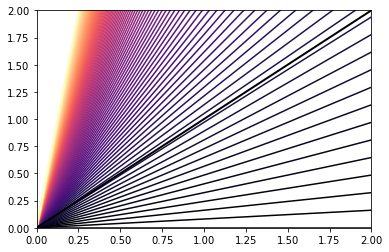

In [24]:
# it's time to talk about prior choices

# std > 0 seems a no brainer. But the situation is actually more complex.

# we need to consider which region of data space the prior prefers.
# Consider the following model for a line


# this is a representative sampling for a flat prior on the slope

a = 0
b = np.linspace(0, 8, num=100)

# yet, in data space, it looks like

plt.figure()

colors = plt.cm.magma(np.linspace(0, 1, num=len(b)))

for i in range(len(b)):
    _ = plt.plot(x, a+b[i]*x, color=colors[i])

plt.xlim([0,2])
plt.ylim([0,2])

plt.plot(x, x, linewidth=2, color='k')



# close to the line x=0, the sampling gets much denser
# --> we are artificially prefering steeper slopes

# so you actually want to sample alpha = tan-1 b
# flat of alpha, is prior(b) ~ 1/(1+b^2) (transformation law)

# similarly, it is good practise to sample log sigma, if sigma>0

# Homework: show that b drawn from prior(b) ~ 1/(1+b^2)
# places the same amount of lines above and below the 
# 1-1 line.

Number of lines above 1-1 line (b > 1): 56
Number of lines below 1-1 line (b < 1): 44
Symmetry ratio: 1.273


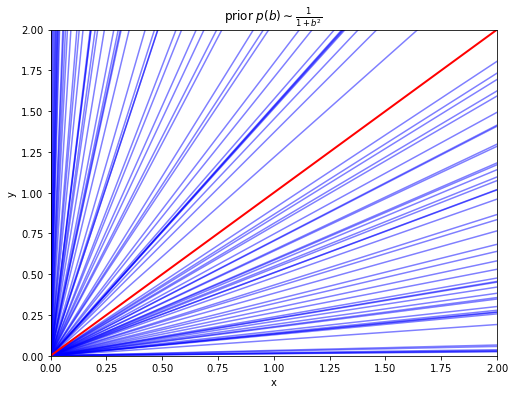

In [43]:
n_samples = 100


u = rng.uniform(size=n_samples)
alpha  = 1. / (1+(u**2))
b_samples = np.tan(np.pi *(alpha - 0.5))  # Transform uniform to Cauchy-like


above_count = np.sum(b_samples > 1)
below_count = np.sum(b_samples < 1)


print(f"Number of lines above 1-1 line (b > 1): {above_count}")
print(f"Number of lines below 1-1 line (b < 1): {below_count}")
print(f"Symmetry ratio: {above_count / below_count:.3f}")


x = np.linspace(0, 2, 1000)

plt.figure(figsize=(8, 6))
for b in b_samples:
    plt.plot(x, b * x, color="b", alpha=0.5)



plt.plot(x, x, color="red", linewidth=2)
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.xlabel("x")
plt.ylabel("y")
plt.title("prior $p(b) \\sim \\frac{1}{1+b^2}$")
plt.show()

